# Setup

In [ ]:
#@title Setup
import os, re, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

import os, re, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install surprise
from surprise import Dataset, Reader
from surprise import NMF
from surprise.model_selection import cross_validate,KFold
from surprise.prediction_algorithms.knns import KNNWithMeans
from joblib import Parallel, delayed

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import SVD

Mounted at /content/drive
     |████████████████████████████████| 11.8 MB 10.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630175 sha256=6af5930fd9ccca3d853b9d659c843b8a762be31c6601c9625064522a9e7ef6b3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# DataSet

In [ ]:
#@title Get all CSVs
ratings = pd.read_csv("/content/drive/Shareddrives/ece219/project 3/ratings.csv")
movies = pd.read_csv("/content/drive/Shareddrives/ece219/project 3/movies.csv")
tags = pd.read_csv("/content/drive/Shareddrives/ece219/project 3/tags.csv")
links = pd.read_csv("/content/drive/Shareddrives/ece219/project 3/links.csv")

In [ ]:
#@markdown 1A: Calculate **Sparsity** of the movie rating dataset.
ratings_matrix = ratings.pivot_table("rating", "userId", "movieId", fill_value = 0)
num_users, num_movies = ratings_matrix.shape
num_possible_ratings = num_users * num_movies
num_available_ratings = len(ratings)
sparsity = num_available_ratings / num_possible_ratings
print("Sparsity: {}".format(sparsity))

Sparsity: 0.016999683055613623


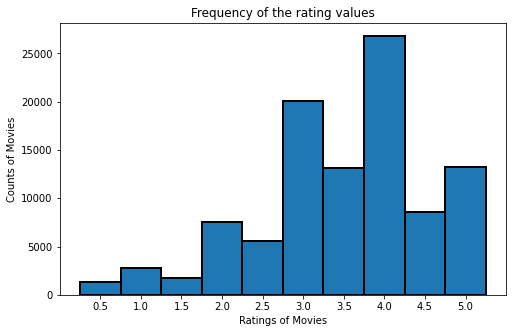

In [ ]:
#@markdown 1B: Histogram showing the frequency of the rating values
unique_ratings, counts = np.unique(ratings["rating"].values, return_counts=True)
plt.subplots(figsize=(8,5))
plt.bar(unique_ratings, counts, width=0.5, edgecolor='black', linewidth=2)
plt.title("Frequency of the rating values")
plt.xlabel("Ratings of Movies")
plt.ylabel("Counts of Movies")
plt.xticks(unique_ratings)
plt.show()

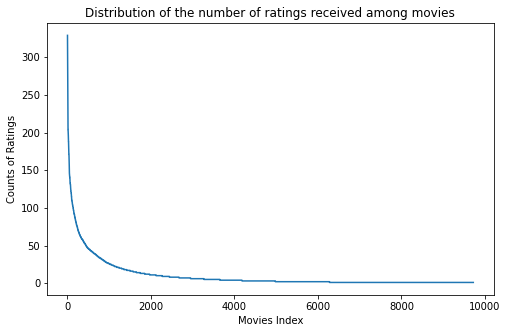

In [ ]:
#@markdown 1C: Distribution of the number of ratings received among movies
plt.subplots(figsize=(8,5))
plt.plot(np.sum(ratings_matrix != 0).sort_values(ascending=False).values)
plt.title("Distribution of the number of ratings received among movies")
plt.xlabel("Movies Index")
plt.ylabel("Counts of Ratings")
plt.show()

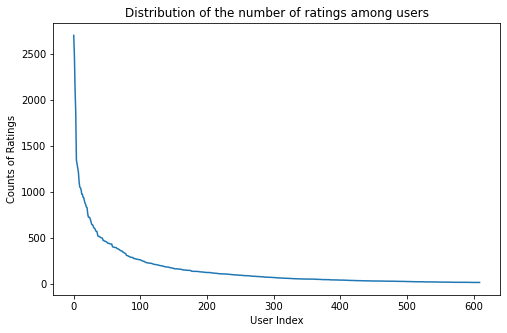

In [ ]:
#@markdown 1D: Ddistribution of ratings among users
plt.subplots(figsize=(8,5))
plt.plot(np.sum(ratings_matrix != 0, axis=1).sort_values(ascending=False).values)
plt.title("Distribution of the number of ratings among users")
plt.xlabel("User Index")
plt.ylabel("Counts of Ratings")
plt.show()

In [ ]:
#@markdown 1E: Salient feature of the distribution

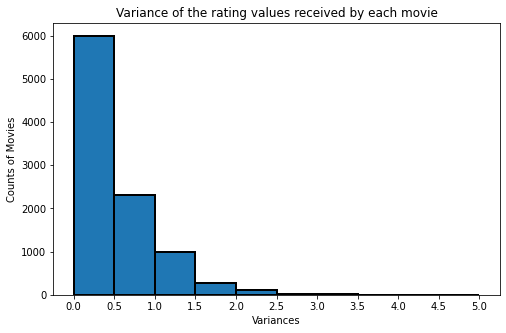

In [ ]:
#@markdown 1F: Compute the variance of the rating values received by each movie
bins = np.linspace(0,5,num=11)
plt.subplots(figsize=(8,5))
plt.hist(np.var(ratings.pivot_table("rating", "userId", "movieId")).values,bins=bins,edgecolor='black', linewidth=2)
plt.title("Variance of the rating values received by each movie")
plt.xlabel("Variances")
plt.ylabel("Counts of Movies")
plt.xticks(bins)
plt.show()

# Neighborhood-based collaborative filtering

In [ ]:
#@markdown 4: k-NN collaborative filter. WARNING: THIS SECTION REQUIRES HIGH RAM


reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

avg_rmse = []
avg_mae = []
ks = np.linspace(2,100,dtype=int)

for k in ks:
    perf = cross_validate(KNNWithMeans(k=k,sim_options={'name':'pearson'}),data,cv=10)
    avg_rmse.append(np.mean(perf['test_rmse']))
    avg_mae.append(np.mean(perf['test_mae']))



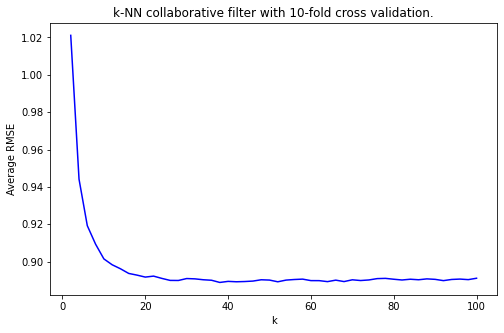

In [ ]:
#@markdown 4A. KNN filter: Plot k against RMSE
#avg_rmse, avg_mae = zip(*Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(delayed(knn_cv_err)(k) for k in zip(ks)))
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ks,avg_rmse, 'b')
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.title("k-NN collaborative filter with 10-fold cross validation.")
plt.show()

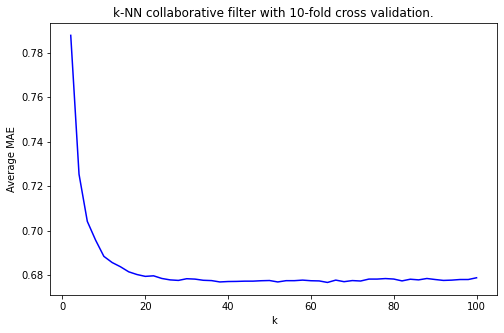

In [ ]:
#@markdown 4B. KNN filter: Plot k against MAE
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ks, avg_mae, 'b')
plt.xlabel("k")
plt.ylabel("Average MAE")
plt.title("k-NN collaborative filter with 10-fold cross validation.")
plt.show()

In [ ]:
#@markdown 5: Find a ’minimum k’.

for i in range(len(ks)):
    if((abs(avg_rmse[i]-avg_rmse[i+1])<0.001)):
        print("Minimum k for which RMSE converges: %s, with average RMSE: %.4f" %(ks[i], avg_rmse[i]))
        break

for i in range(len(ks)):
    if((abs(avg_mae[i]-avg_mae[i+1])<0.001)):
        print("Minimum k for which MAE converges: %s, with average MAE: %.4f" %(ks[i], avg_mae[i]))
        break

Minimum k for which RMSE converges: 16, with average RMSE: 0.8942
Minimum k for which MAE converges: 16, with average MAE: 0.6815


In [ ]:
#@markdown 6: k-NN collaborative filter for each of the 3 subsets in the test set. WARNING: THIS SECTION REQUIRES HIGH RAM


reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)
data_df = ratings.pivot_table('rating', 'userId', 'movieId')
variance = np.var(data_df, axis=0)
kf = KFold(n_splits=10)
ks = np.linspace(2,100,dtype=int)
ref = {}
for rate in data.raw_ratings:
    if rate[1] in ref.keys():
        ref[rate[1]].append(rate[2])
    else:
        ref[rate[1]] = []
        ref[rate[1]].append(rate[2])


In [ ]:
#@markdown Trmming methods
def popular_trimming(testset,ref):
  return [i for i in testset if len(ref[i[1]]) > 2]

def unpopular_trimming(testset,ref):
  return [i for i in testset if len(ref[i[1]]) <= 2]

def high_variance_trimming(testset, ref, variance):
  return [i for i in testset if (len(ref[i[1]]) >=5 and i[1] in variance[variance>=2].keys())]
  

In [ ]:
#@markdown Plot ROC Function
def plot_roc_curves(testset, trim, prediction, threshold=[2.5, 3, 3.5, 4]):
  for t in threshold:
    plt.gcf().clear()
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    y_true, y_pred = [], []
    for i in range(len(testset)):
        y_true.append(1 * (testset[i][2] >= t))
        y_pred.append(prediction[i].est)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f' %(t,auc_score), linewidth=2)
    title =''
    if trim == 'popular':
      title = 'Popular Movie Trimming'
    elif trim == 'unpopular':
      title = 'Unpopular Movie Trimming'
    elif trim == 'high variance':
      title = 'High Variance Movie Trimming'
    else:
      title = trim
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curves for {}'.format(title), fontweight="bold")
    plt.show()

Minimum average RMSE for Popular Movie Trimming:  0.872540577170912


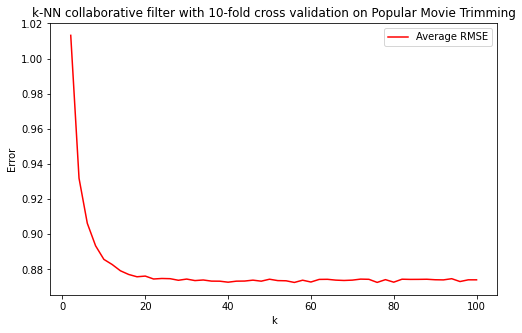

In [ ]:
#@markdown 6A. Popular trimming
avg_rmse_pop=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        pop_trim = popular_trimming(testset,ref)
        pred = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(pop_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    avg_rmse_pop.append(rmse/10.0)

print("Minimum average RMSE for Popular Movie Trimming: ", min(avg_rmse_pop))
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ks,avg_rmse_pop, 'r', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("k-NN collaborative filter with 10-fold cross validation on Popular Movie Trimming")
plt.show()

In [ ]:
#@markdown Find minimum k for popular movies
for i in range(len(ks)):
    if((abs(avg_rmse_pop[i]-avg_rmse_pop[i+1])<0.001)):
        print("Minimum k for which RMSE converges: %s, with average RMSE: %.4f" %(ks[i], avg_rmse_pop[i]))
        rmse_best_k_pop = ks[i]
        break

Minimum k for which RMSE converges: 18, with average RMSE: 0.8758


<Figure size 432x288 with 0 Axes>

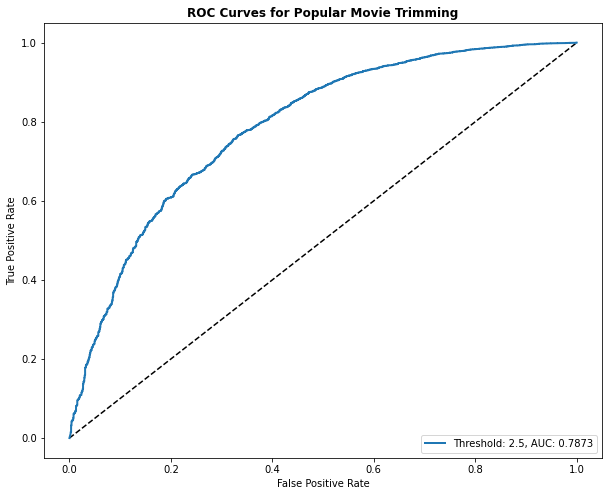

<Figure size 432x288 with 0 Axes>

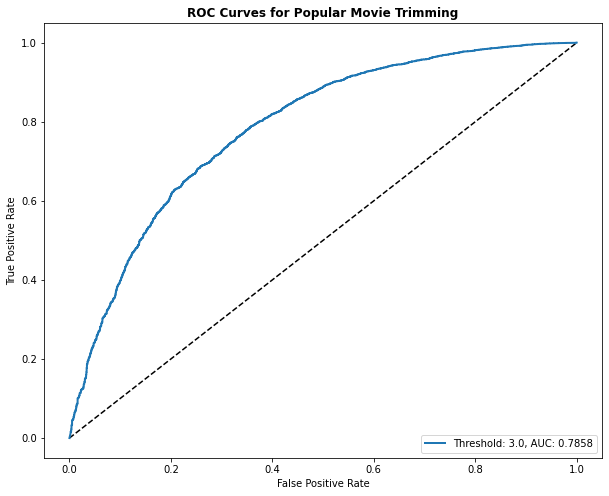

<Figure size 432x288 with 0 Axes>

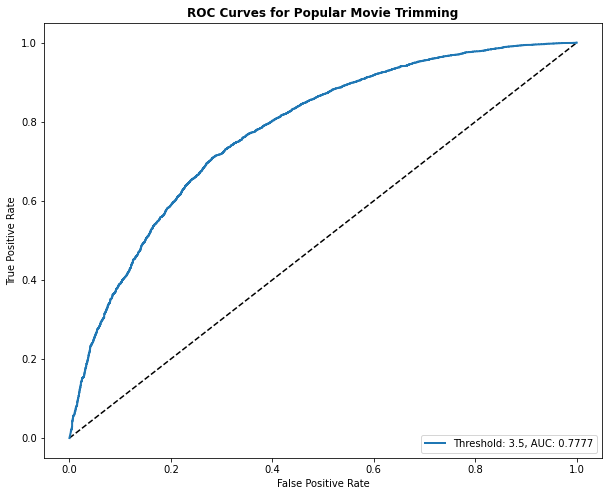

<Figure size 432x288 with 0 Axes>

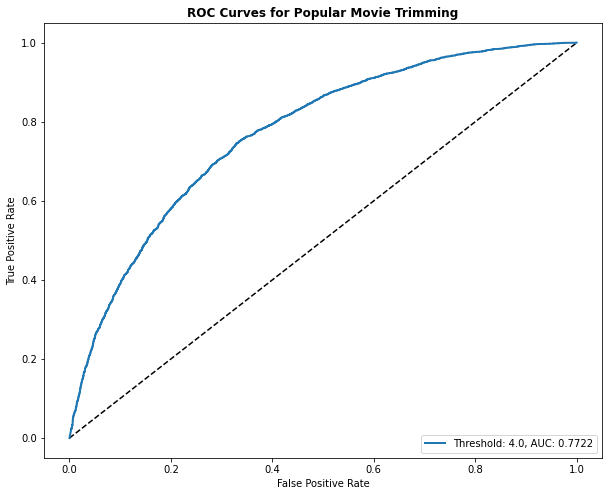

In [ ]:
#@markdown Plot ROC Curves for popular movie trimming
trainset, testset = train_test_split(data, test_size=0.1)
pop_trim = popular_trimming(testset,ref)
knn_best_pop = KNNWithMeans(k=rmse_best_k_pop, sim_options={'name': 'pearson'}, verbose=False)
knn_best_pop.fit(trainset)
knn_best_pred_pop = knn_best_pop.test(pop_trim)
plot_roc_curves(pop_trim, 'popular', knn_best_pred_pop, threshold=[2.5,3,3.5,4])

Minimum average RMSE for Unpopular Movie Trimming:  1.1118567762614087


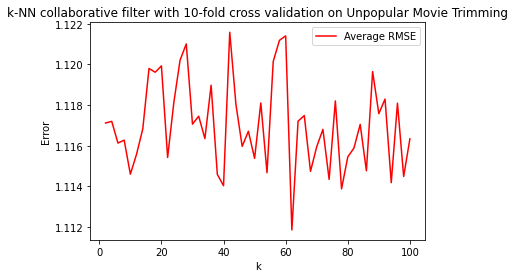

In [ ]:
#@markdown 6B. Unpopular trimming
avg_rmse_unpop=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        unpop_trim = unpopular_trimming(testset,ref)
        pred = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(unpop_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    avg_rmse_unpop.append(rmse/10.0)

print("Minimum average RMSE for Unpopular Movie Trimming: ",min(avg_rmse_unpop))
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ks,avg_rmse_unpop, 'r', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("k-NN collaborative filter with 10-fold cross validation on Unpopular Movie Trimming")
plt.show()

<Figure size 432x288 with 0 Axes>

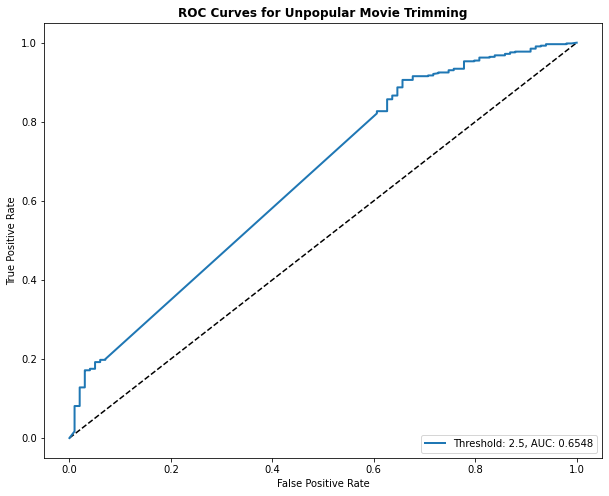

<Figure size 432x288 with 0 Axes>

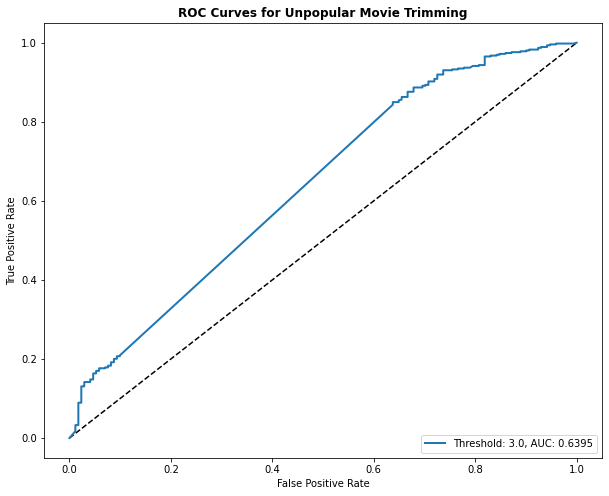

<Figure size 432x288 with 0 Axes>

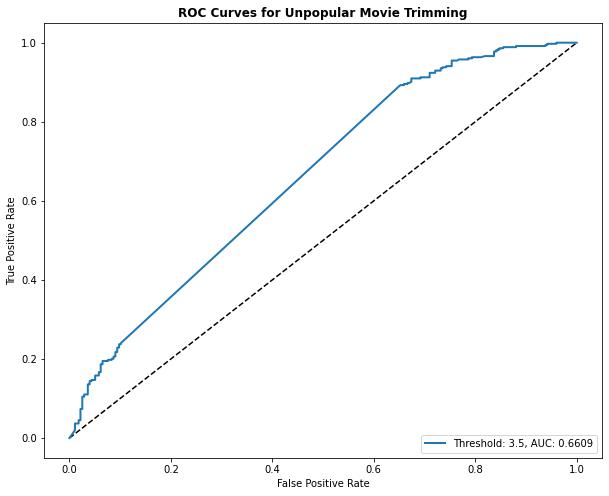

<Figure size 432x288 with 0 Axes>

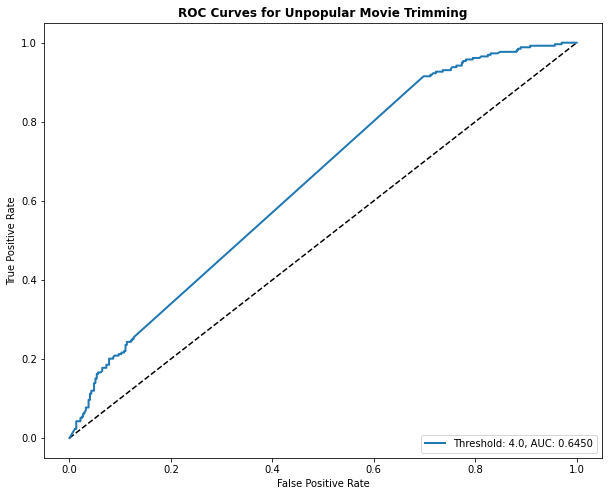

In [ ]:
#@markdown Plot ROC Curves for unpopular movie trimming
trainset, testset = train_test_split(data, test_size=0.1)
unpop_trim = unpopular_trimming(testset,ref)
knn_best_unpop = KNNWithMeans(k=62, sim_options={'name': 'pearson'}, verbose=False)
knn_best_unpop.fit(trainset)
knn_best_pred_unpop = knn_best_unpop.test(unpop_trim)
plot_roc_curves(unpop_trim, 'unpopular', knn_best_pred_unpop, threshold=[2.5,3,3.5,4])

Minimum average RMSE for High Variance Movie Trimming:  1.4714936860163954


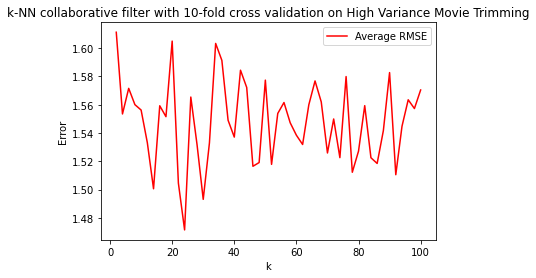

In [ ]:
#@markdown 6C. High variance trimming
avg_rmse_var=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        high_var_trim = high_variance_trimming(testset,ref,variance)
        pred = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(high_var_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    avg_rmse_var.append(rmse/10.0)

print("Minimum average RMSE for High Variance Movie Trimming: " ,min(avg_rmse_var))
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ks,avg_rmse_var, 'r', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k")
plt.ylabel("Error")
plt.title("k-NN collaborative filter with 10-fold cross validation on High Variance Movie Trimming")
plt.show()

<Figure size 432x288 with 0 Axes>

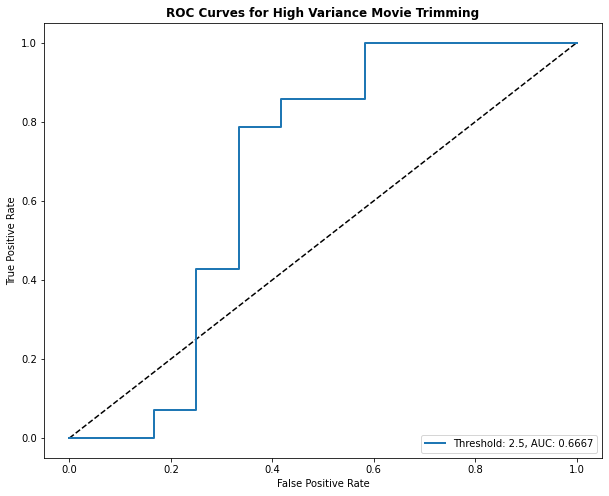

<Figure size 432x288 with 0 Axes>

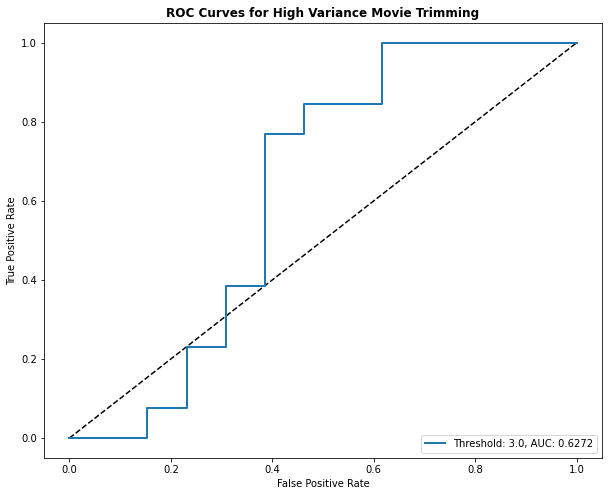

<Figure size 432x288 with 0 Axes>

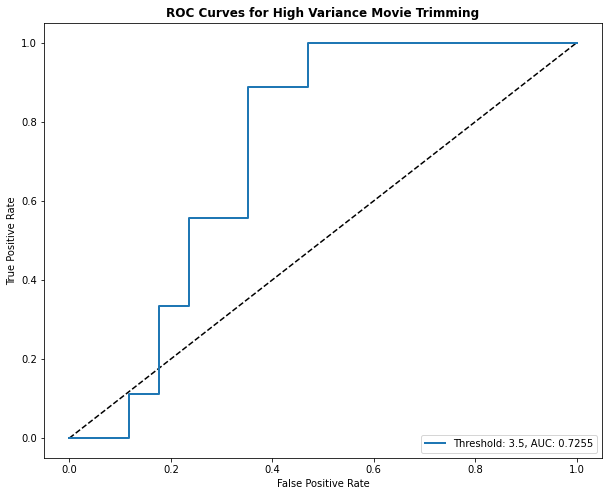

<Figure size 432x288 with 0 Axes>

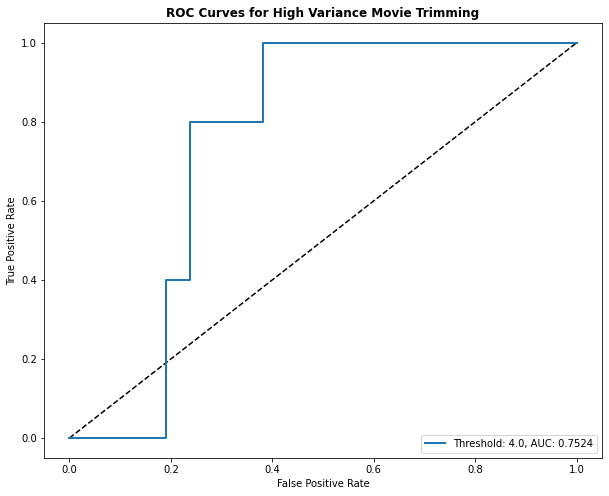

In [ ]:
#@markdown Plot ROC Curves for high variance trimming
trainset, testset = train_test_split(data, test_size=0.1)
high_var_trim = high_variance_trimming(testset,ref,variance)
knn_best_var = KNNWithMeans(k=24, sim_options={'name': 'pearson'}, verbose=False)
knn_best_var.fit(trainset)
knn_best_pred_var = knn_best_var.test(high_var_trim)
plot_roc_curves(high_var_trim, 'high variance', knn_best_pred_var, threshold=[2.5,3,3.5,4])

# Model-Based Collaborative Filtering

In [ ]:
#@markdown 7.Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

In [ ]:
#@markdown 8A. Design a NMF-based collaborative filter
from surprise import NMF
RMSEs = []
MAEs = []
for k in range(2, 52, 2):
  nmf = NMF(n_factors = k)
  cv = cross_validate(nmf, data, measures=['rmse', 'mae'], cv=10, verbose=False)
  RMSEs.append(np.mean(cv["test_rmse"]))
  MAEs.append(np.mean(cv["test_mae"]))

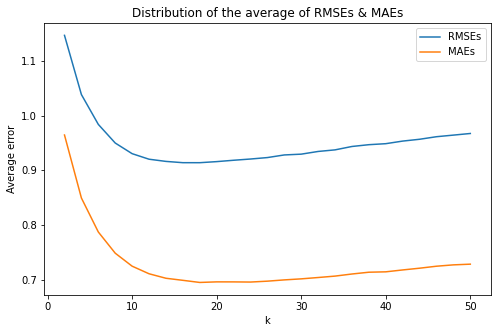

In [ ]:
#@markdown 8A: Ddistribution of the average of RMSEs and MAEs
plt.subplots(figsize=(8,5))
plt.plot(np.arange(2, 52, 2), RMSEs, label="RMSEs")
plt.plot(np.arange(2, 52, 2), MAEs, label="MAEs")
plt.title("Distribution of the average of RMSEs & MAEs")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average error")
plt.show()

In [ ]:
#@markdown 8B. MIN RMSE and MAE and their corresponding numbers of latents
min_RMSE = min(RMSEs)
min_MAE = min(MAEs)
num_latent_RMSE = np.arange(2, 52, 2)[RMSEs.index(min_RMSE)]
num_latent_MAE = np.arange(2, 52, 2)[MAEs.index(min_MAE)]
print("RMSE: optimal number of latents = {}, MIN RMSE = {}".format(num_latent_RMSE, min_RMSE))
print("MAE: optimal number of latents = {}, MIN MAE = {}".format(num_latent_MAE, min_MAE))

unique_genres = set()
for genres in list(movies.genres):
  for genre in genres.split("|"):
    if genre != "(no genres listed)":
      unique_genres.add(genre.lower())
print("Total number of genres = {}".format(len(unique_genres)))

RMSE: optimal number of latents = 18, MIN RMSE = 0.9137200870387338
MAE: optimal number of latents = 18, MIN MAE = 0.6947181410139807
Total number of genres = 19


In [ ]:
#@markdown 8C. Performance on trimmed Test set subsets: Popular Movies
kf = KFold(n_splits=10)
RMSEs_pop = []
for k in range(2, 52, 2):
  nmf = NMF(n_factors = k)
  RMSEs_at_k = []
  for trainset, testset, in kf.split(data):
    nmf.fit(trainset)
    pred = nmf.test(popular_trimming(testset, ref))
    RMSEs_at_k.append(accuracy.rmse(pred, verbose=False))
  RMSEs_pop.append(np.mean(RMSEs_at_k))


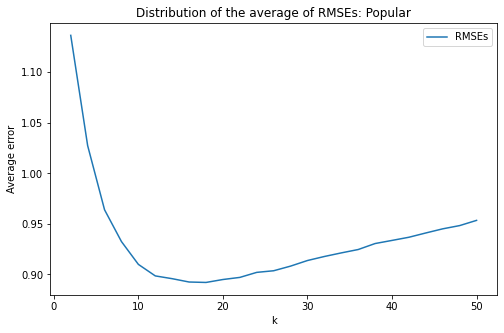

Popular: optimal number of latents = 18, MIN RMSE = 0.892027822579608


In [ ]:
#@markdown 8C. Plot RMSE against k: Popular Movies; report MIN RMSE
plt.subplots(figsize=(8,5))
plt.plot(np.arange(2, 52, 2), RMSEs_pop, label="RMSEs")
plt.title("Distribution of the average of RMSEs: Popular")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average error")
plt.show()

min_RMSE_pop = min(RMSEs_pop)
num_latent_RMSE_pop = np.arange(2, 52, 2)[RMSEs_pop.index(min_RMSE_pop)]
print("Popular: optimal number of latents = {}, MIN RMSE = {}".format(num_latent_RMSE_pop, min_RMSE_pop))

In [ ]:
#@markdown 8C. Performance on trimmed Test set subsets: Unpopular Movies
kf = KFold(n_splits=10)
RMSEs_unpop = []
for k in range(2, 52, 2):
  nmf = NMF(n_factors = k)
  RMSEs_at_k = []
  for trainset, testset, in kf.split(data):
    nmf.fit(trainset)
    pred = nmf.test(unpopular_trimming(testset, ref))
    RMSEs_at_k.append(accuracy.rmse(pred, verbose=False))
  RMSEs_unpop.append(np.mean(RMSEs_at_k))

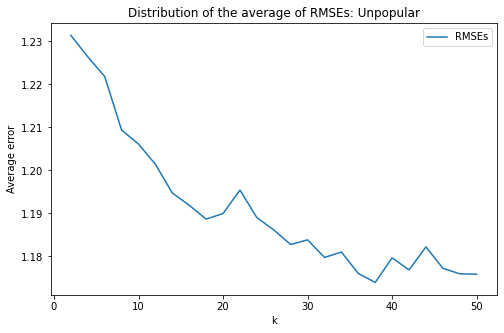

Unpopular: optimal number of latents = 38, MIN RMSE = 1.1739349455959827


In [ ]:
#@markdown 8C. Plot RMSE against k: Unpopular Movies; report MIN RMSE
plt.subplots(figsize=(8,5))
plt.plot(np.arange(2, 52, 2), RMSEs_unpop, label="RMSEs")
plt.title("Distribution of the average of RMSEs: Unpopular")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average error")
plt.show()

min_RMSE_unpop = min(RMSEs_unpop)
num_latent_RMSE_unpop = np.arange(2, 52, 2)[RMSEs_unpop.index(min_RMSE_unpop)]
print("Unpopular: optimal number of latents = {}, MIN RMSE = {}".format(num_latent_RMSE_unpop, min_RMSE_unpop))

In [ ]:
#@markdown 8C. Performance on trimmed Test set subsets: High Vairance
kf = KFold(n_splits=10)
RMSEs_hv = []
for k in range(2, 52, 2):
  nmf = NMF(n_factors = k)
  RMSEs_at_k = []
  for trainset, testset, in kf.split(data):
    nmf.fit(trainset)
    pred = nmf.test(high_variance_trimming(testset, ref, variance))
    RMSEs_at_k.append(accuracy.rmse(pred, verbose=False))
  RMSEs_hv.append(np.mean(RMSEs_at_k))

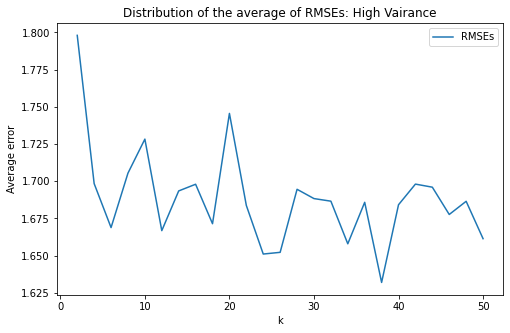

High Variance: optimal number of latents = 38, MIN RMSE = 1.6320165170685157


In [ ]:
#@markdown 8C. Plot RMSE against k: High Vairance
plt.subplots(figsize=(8,5))
plt.plot(np.arange(2, 52, 2), RMSEs_hv, label="RMSEs")
plt.title("Distribution of the average of RMSEs: High Vairance")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average error")
plt.show()

min_RMSE_hv = min(RMSEs_hv)
num_latent_RMSE_hv = np.arange(2, 52, 2)[RMSEs_hv.index(min_RMSE_hv)]
print("High Variance: optimal number of latents = {}, MIN RMSE = {}".format(num_latent_RMSE_hv, min_RMSE_hv))

<Figure size 432x288 with 0 Axes>

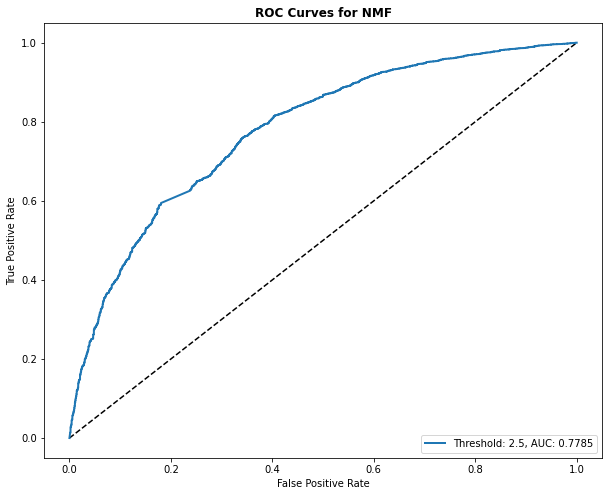

<Figure size 432x288 with 0 Axes>

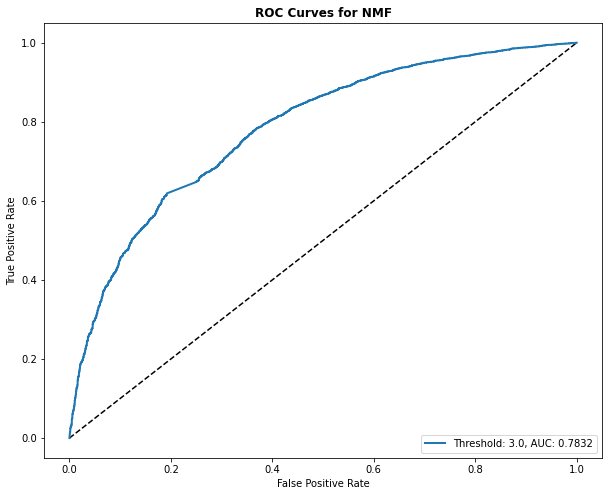

<Figure size 432x288 with 0 Axes>

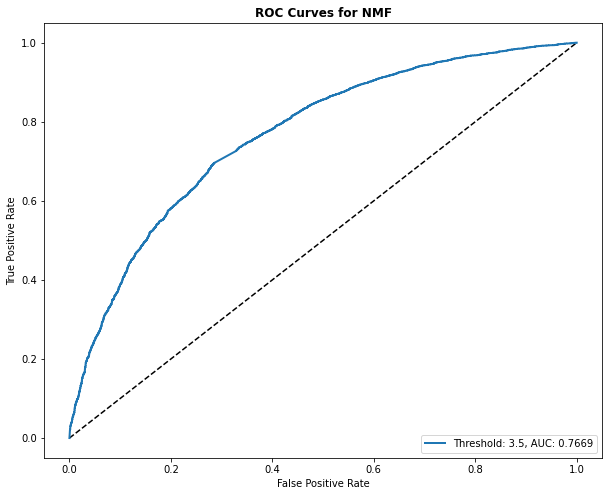

<Figure size 432x288 with 0 Axes>

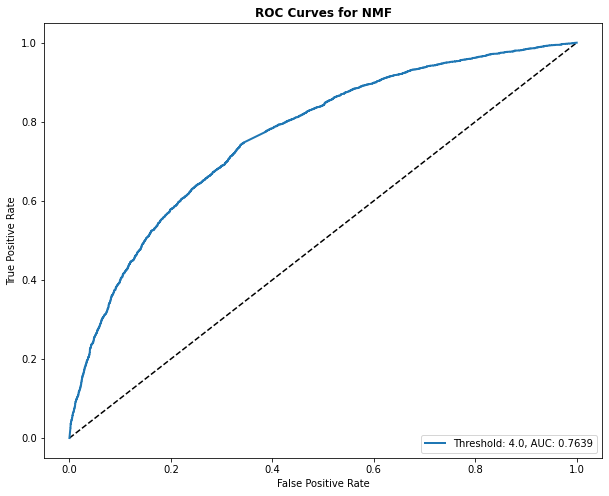

In [ ]:
#@markdown 8D. Plot ROC based on 8A & 8B
trainset, testset = train_test_split(data, test_size=0.1)
nmf_optimal = NMF(n_factors = 18)
nmf_optimal.fit(trainset)
nmf_optimal_pred_var = nmf_optimal.test(testset)
plot_roc_curves(testset, 'NMF', nmf_optimal_pred_var, threshold=[2.5,3,3.5,4])

In [ ]:
#@ markdown 9 Interpreting the NMF model
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# Use the whole set
trainset = data.build_full_trainset()

nmf_20 = NMF(n_factors=20, random_state=42)
nmf_20.fit(trainset)
factors = nmf_20.qi

def interpret_latent_factor(num_latent_factors, factors):
    for i in range(num_latent_factors):
        movie_ids = np.argsort(-factors[:,i])[0:10]
        print(f"Latent Factor {i}")
        val = factors[movie_ids, i]
        for j in range(10):
          genre = movies.iloc[movie_ids[j]]['genres']
          print(f"Value: {val[j]} Genre: {genre}")
        print("***********************************************\n")
interpret_latent_factor(20, factors)


Latent Factor 0
Value: 3.7848256913679013 Genre: Children|Fantasy|Musical
Value: 2.064498013094972 Genre: Comedy
Value: 1.9911374299385998 Genre: Drama|Romance|War
Value: 1.7856744520278218 Genre: Drama|Romance
Value: 1.73824321790576 Genre: Drama|Romance
Value: 1.7201761803704592 Genre: Horror|Mystery|Thriller
Value: 1.6826198015015532 Genre: Comedy|Drama|Romance
Value: 1.6735078544466162 Genre: Adventure|Drama|Sci-Fi
Value: 1.6399498314892 Genre: Comedy|Drama
Value: 1.6050421325932336 Genre: Comedy|Romance
***********************************************

Latent Factor 1
Value: 2.0771141611302353 Genre: Comedy
Value: 1.695844043792044 Genre: Drama
Value: 1.6858422876849746 Genre: Drama
Value: 1.6651689669224274 Genre: Comedy|Romance
Value: 1.6524899942741256 Genre: Action|Sci-Fi|Thriller
Value: 1.6088770551446494 Genre: Action|Crime|Drama|Thriller
Value: 1.5888115207191555 Genre: Adventure|Children
Value: 1.561209437403634 Genre: Animation|Children
Value: 1.558920278044601 Genre: Dram

In [ ]:
#@markdown 10. Designing the MF Collaborative Filter
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

mf_rmse = []
mf_mae = []
ks = np.linspace(2,50,dtype=int)

for k in ks:
  mf = SVD(n_factors = k)
  perf = cross_validate(mf,data,cv=10)
  mf_rmse.append(np.mean(perf['test_rmse']))
  mf_mae.append(np.mean(perf['test_mae']))


Text(0.5, 1.0, 'MF collaborative filter with 10-fold cross validation.')

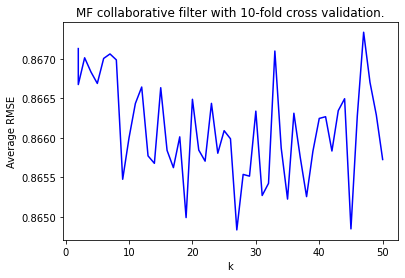

In [ ]:
fig, ax = plt.subplots()
ax.plot(ks,mf_rmse, 'b')
plt.xlabel("k"); plt.ylabel("Average RMSE"); plt.title("MF collaborative filter with 10-fold cross validation.")

Text(0.5, 1.0, 'MF collaborative filter with 10-fold cross validation.')

<Figure size 432x288 with 0 Axes>

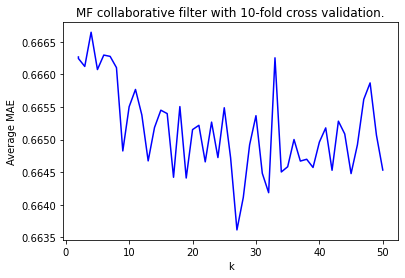

In [ ]:
plt.gcf().clear()
fig, ax = plt.subplots()
ax.plot(ks, mf_mae, 'b')
plt.xlabel("k"); plt.ylabel("Average MAE"); plt.title("MF collaborative filter with 10-fold cross validation.")

In [ ]:
print("Minimum average RMSE: %.4f; Optimal number of latent factors: %s" %(np.min(mf_rmse), ks[np.argmin(mf_rmse)]))
print("Minimum average MAE: %.4f; Optimal number of latent factors: %s" %(np.min(mf_mae), ks[np.argmin(mf_mae)]))

Minimum average RMSE: 0.8648; Optimal number of latent factors: 27
Minimum average MAE: 0.6636; Optimal number of latent factors: 27


In [ ]:
# from surprise.model_selection import KFold
# from surprise import accuracy
data_df = ratings.pivot_table('rating', 'userId', 'movieId')
variance = np.var(data_df, axis=0)
kf = KFold(n_splits = 10)
ref = {}
for rate in data.raw_ratings:
    if rate[1] in ref.keys():
        ref[rate[1]].append(rate[2])
    else:
        ref[rate[1]] = []
        ref[rate[1]].append(rate[2])

Minimum average RMSE for Popular Movie Trimming:  0.8576405956241911


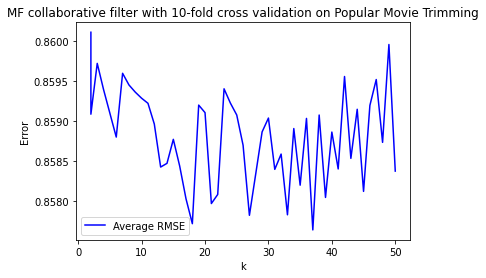

In [ ]:
#popular trimming
mf_rmse_pop=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        pop_trim = popular_trimming(testset,ref)
        pred = SVD(n_factors = k).fit(trainset).test(pop_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    mf_rmse_pop.append(rmse/10.0)

print("Minimum average RMSE for Popular Movie Trimming: ", min(mf_rmse_pop))
fig, ax = plt.subplots()
ax.plot(ks,mf_rmse_pop, 'b', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k"); plt.ylabel("Error"); plt.title("MF collaborative filter with 10-fold cross validation on Popular Movie Trimming")
plt.show()

In [ ]:
print("Minimum average RMSE for popular movie trimming dataset: %.4f" %np.min(mf_rmse_pop))

Minimum average RMSE for popular movie trimming dataset: 0.8576


Minimum average RMSE for Unpopular Movie Trimming:  0.9700432198598825


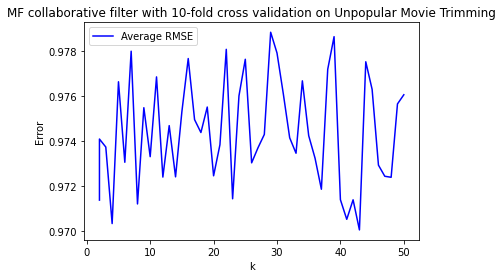

In [ ]:
# unpopular trimming
mf_rmse_unpop=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        unpop_trim = unpopular_trimming(testset,ref)
        pred = SVD(n_factors = k).fit(trainset).test(unpop_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    mf_rmse_unpop.append(rmse/10.0)

print("Minimum average RMSE for Unpopular Movie Trimming: ",min(mf_rmse_unpop))
fig, ax = plt.subplots()
ax.plot(ks,mf_rmse_unpop, 'b', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k"); plt.ylabel("Error"); plt.title("MF collaborative filter with 10-fold cross validation on Unpopular Movie Trimming")
plt.show()

In [ ]:
print("Minimum average RMSE for unpopular movie trimming dataset: %.4f" %np.min(mf_rmse_unpop))

Minimum average RMSE for unpopular movie trimming dataset: 0.9700


Minimum average RMSE for High Variance Movie Trimming:  1.4463300601631643


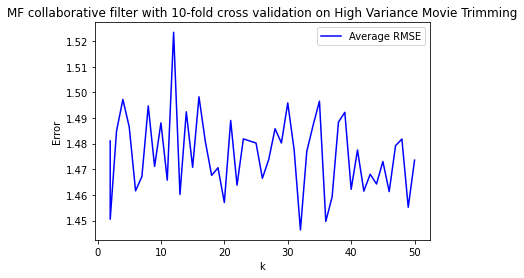

In [ ]:
#high variance trimming
mf_rmse_var=[]
for k in ks:
    rmse = 0
    for trainset, testset in kf.split(data):
        high_var_trim = high_variance_trimming(testset,ref,variance)
        pred = SVD(n_factors = k).fit(trainset).test(high_var_trim)
        rmse += accuracy.rmse(pred,verbose=False)
    mf_rmse_var.append(rmse/10.0)

print("Minimum average RMSE for High Variance Movie Trimming: " ,min(mf_rmse_var))
fig, ax = plt.subplots()
ax.plot(ks,mf_rmse_var, 'b', label='Average RMSE')
ax.legend(loc='best')
plt.xlabel("k"); plt.ylabel("Error"); plt.title("MF collaborative filter with 10-fold cross validation on High Variance Movie Trimming")
plt.show()

In [ ]:
print("Minimum average RMSE for high variance movie trimming dataset: %.4f" %np.min(mf_rmse_var))

Minimum average RMSE for high variance movie trimming dataset: 1.4463


<Figure size 432x288 with 0 Axes>

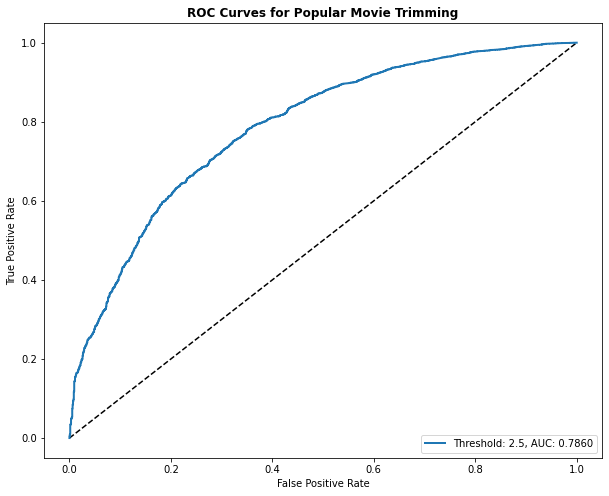

<Figure size 432x288 with 0 Axes>

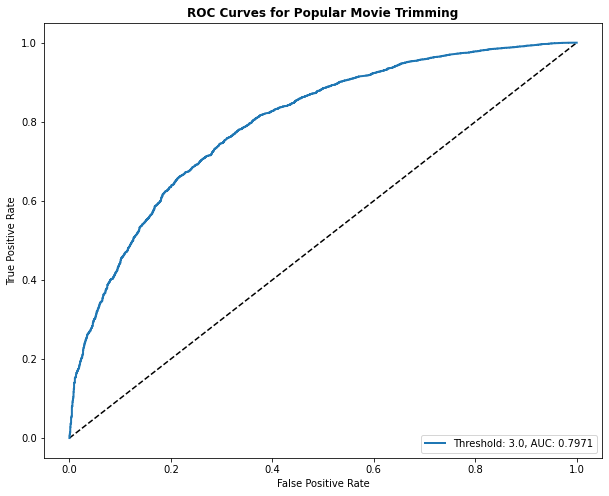

<Figure size 432x288 with 0 Axes>

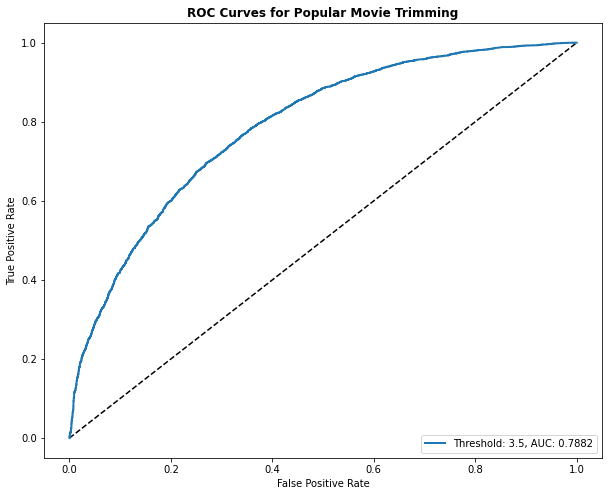

<Figure size 432x288 with 0 Axes>

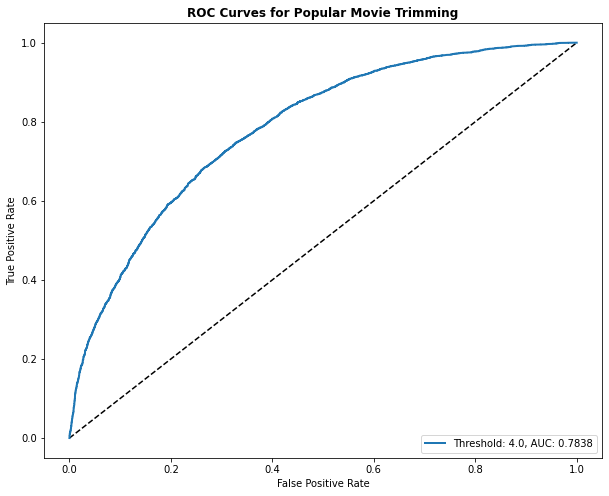

In [ ]:
#@markdown Plot ROC Curves 
trainset, testset = train_test_split(data, test_size=0.1)
mf_best = SVD(n_factors=27)
mf_best.fit(trainset)
mf_best_pred = mf_best.test(testset)
plot_roc_curves(testset, 'popular', mf_best_pred, threshold=[2.5,3,3.5,4])

<Figure size 432x288 with 0 Axes>

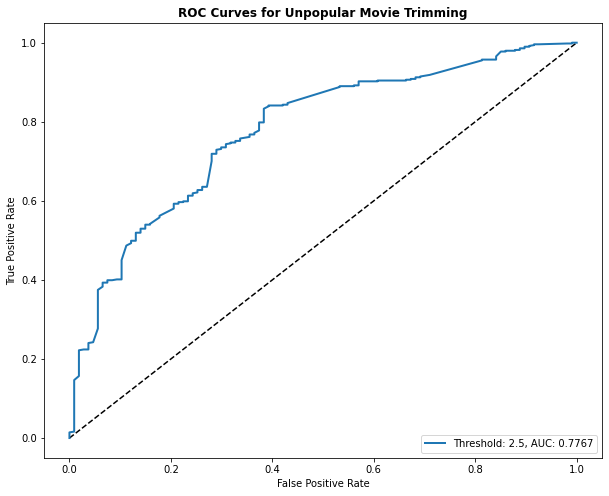

<Figure size 432x288 with 0 Axes>

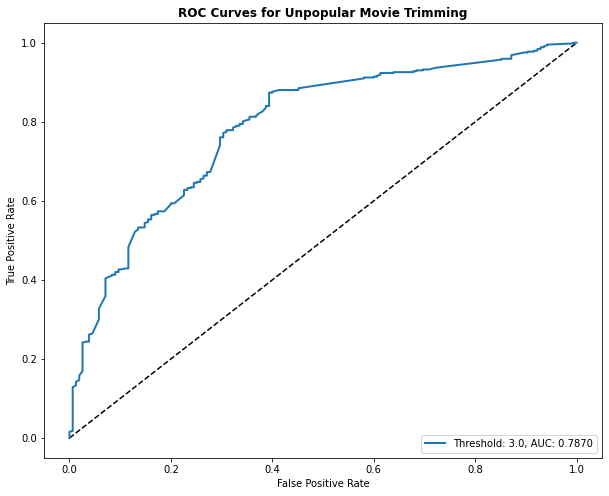

<Figure size 432x288 with 0 Axes>

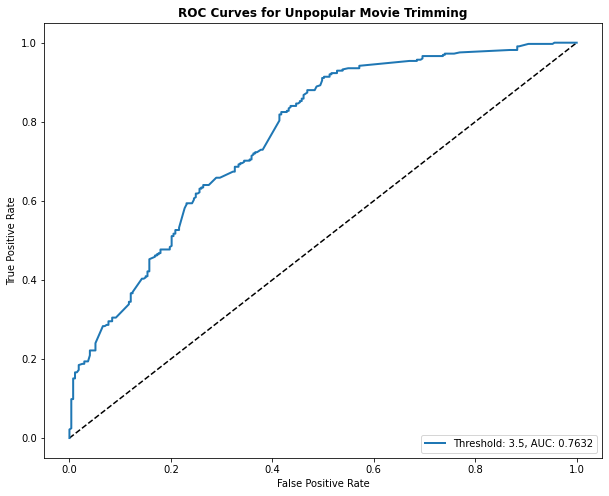

<Figure size 432x288 with 0 Axes>

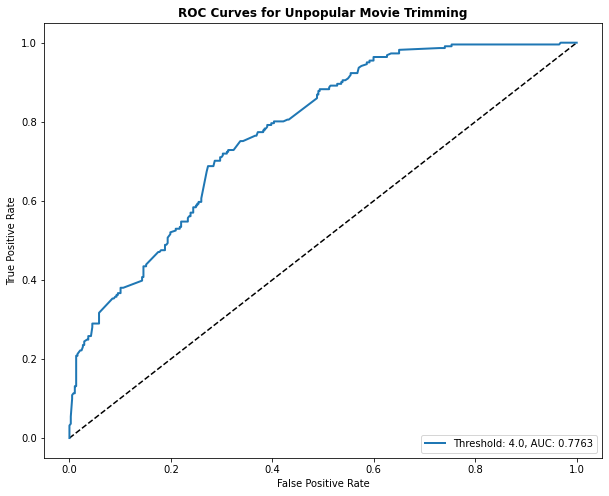

In [ ]:
#@markdown Plot ROC Curves for unpopular movie trimming
trainset, testset = train_test_split(data, test_size=0.1)
unpop_trim = unpopular_trimming(testset,ref)
mf_best_unpop = SVD(n_factors = 27)
mf_best_unpop.fit(trainset)
mf_best_pred_unpop = mf_best_unpop.test(unpop_trim)
plot_roc_curves(unpop_trim, 'unpopular', mf_best_pred_unpop, threshold=[2.5,3,3.5,4])

<Figure size 432x288 with 0 Axes>

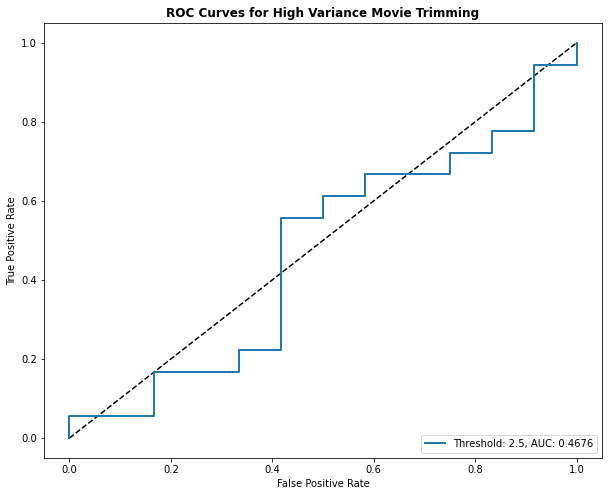

<Figure size 432x288 with 0 Axes>

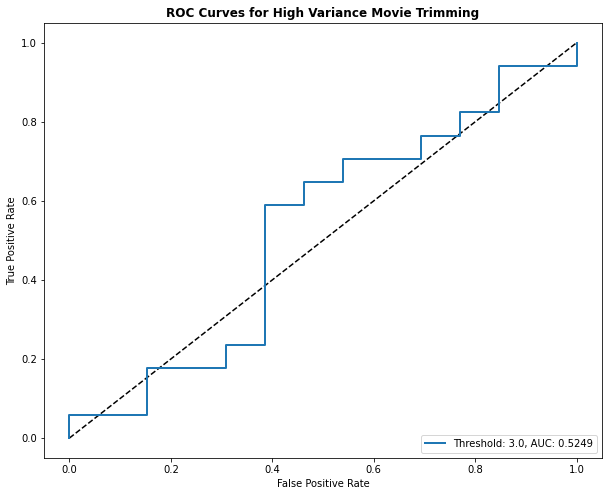

<Figure size 432x288 with 0 Axes>

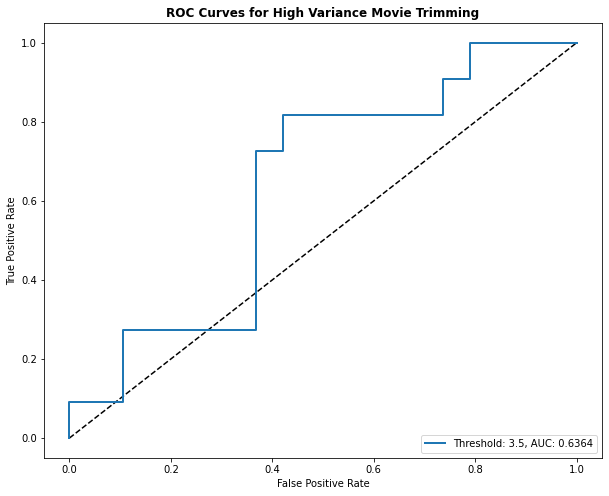

<Figure size 432x288 with 0 Axes>

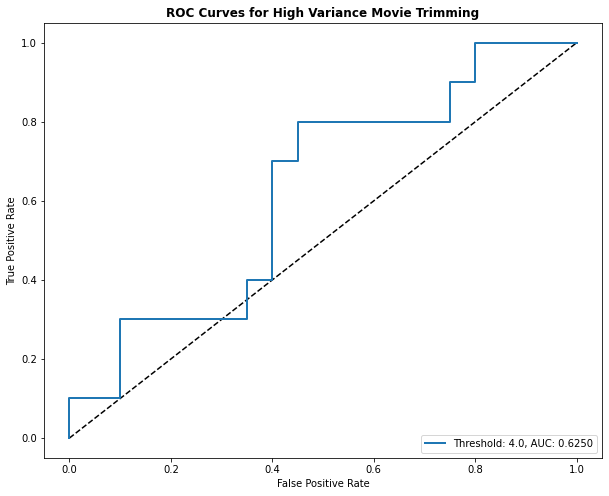

In [ ]:
#@markdown Plot ROC Curves for high variance trimming
trainset, testset = train_test_split(data, test_size=0.1)
high_var_trim = high_variance_trimming(testset,ref,variance)
mf_best_var = SVD(n_factors = 27)
mf_best_var.fit(trainset)
mf_best_pred_var = mf_best_var.test(high_var_trim)
plot_roc_curves(high_var_trim, 'high variance', mf_best_pred_var, threshold=[2.5,3,3.5,4])

# Naive Collaborative Filtering

In [ ]:
#@markdown 11A. Designing a Naive Collaborative Filter
#@markdown - First, get all users and their all ratings given.
users_ratings = {}
for d in data.raw_ratings:
  user_id = d[0]
  movie_rating = d[2]
  if user_id not in users_ratings.keys():
    users_ratings[user_id] = []
  users_ratings[user_id].append(movie_rating)

#@markdown - Then, get all users' average rating given.
users_mean_ratings = {}
for user in users_ratings.keys():
  users_mean_ratings[user] = np.mean(users_ratings[user])

#@markdown - Finally, calculate the average RMSE
kf = KFold(n_splits=10)
rmse_naive = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    pred = [users_mean_ratings[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse_naive += np.sqrt(mean_squared_error(true, pred))
avg_rmse_naive = rmse_naive / 10.0
print("Average RMSE original dataset: {}".format(avg_rmse_naive))

Average RMSE original dataset: 0.9346920832974975


In [ ]:
#@markdown 11B. Performance of Naive Filter on Popular Movies
rmse_pop = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    pop_trim = popular_trimming(testset, ref)
    pred = [users_mean_ratings[i[0]] for i in pop_trim]
    true = [i[2] for i in pop_trim]
    rmse_pop += np.sqrt(mean_squared_error(true,pred))
avg_rmse_pop = rmse_pop / 10.0
print("Average RMSE Popular: {}".format(avg_rmse_pop))

Average RMSE Popular: 0.9323353743715256


In [ ]:
#@markdown 11B. Performance of Naive Filter on Unopular Movies
rmse_unpop = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    unpop_trim = unpopular_trimming(testset, ref)
    pred = [users_mean_ratings[i[0]] for i in unpop_trim]
    true = [i[2] for i in unpop_trim]
    rmse_unpop += np.sqrt(mean_squared_error(true,pred))
avg_rmse_unpop = rmse_unpop / 10.0
print("Average RMSE Unpopular: {}".format(avg_rmse_unpop))

Average RMSE Unpopular: 0.9710808053799356


In [ ]:
#@markdown 11B. Performance of Naive Filter on High Vairance Movies
rmse_hv = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    hv_trim = high_variance_trimming(testset, ref, variance)
    pred = [users_mean_ratings[i[0]] for i in hv_trim]
    true = [i[2] for i in hv_trim]
    rmse_hv += np.sqrt(mean_squared_error(true,pred))
avg_rmse_hv = rmse_hv / 10.0
print("Average RMSE High-Variance: {}".format(avg_rmse_hv))

Average RMSE High-Variance: 1.4743939745307288


In [ ]:
#@markdown Helper: Plot roc curves in one plot.
def plot_roc_curves_one_plot(testset, method, prediction_list, threshold=3):
  plt.gcf().clear()
  plt.figure(figsize=(10,8))
  plt.plot([0, 1], [0, 1], 'k--')
  counter = 0
  for m in method:
    y_true, y_pred = [], []
    for i in range(len(testset)):
        y_true.append(1 * (testset[i][2] >= threshold))
        y_pred.append(prediction_list[counter][i].est)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f, Method: %s' %(threshold,auc_score,m), linewidth=2)
    counter+=1
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.title('ROC Curves across models', fontweight="bold")
  plt.show()
  

<Figure size 432x288 with 0 Axes>

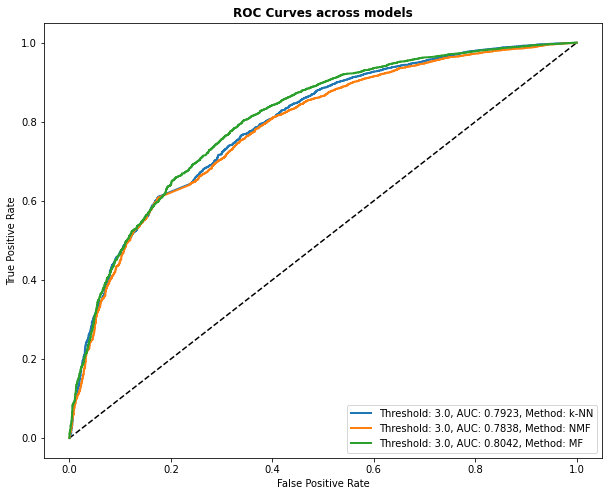

In [ ]:
#@markdown 12. Comparing the most performant models across architecture
trainset, testset = train_test_split(data, test_size=.1)
pred_knn = KNNWithMeans(k=16, sim_options={'name':'pearson'}, verbose=False).fit(trainset).test(testset)
pred_nmf = NMF(n_factors=18, verbose=False).fit(trainset).test(testset)
pred_mf = SVD(n_factors=27, verbose=False).fit(trainset).test(testset)
method_list = ["k-NN","NMF","MF"]
pred_list = [pred_knn,pred_nmf,pred_mf]
plot_roc_curves_one_plot(testset, method_list, pred_list, 3)


# Ranking

In [ ]:
#@markdown 13. Understanding Precision and Recall in the context of Recommender Systems
#@markdown - **Precision**: Based on our datasets, precision is the fraction of user-liked items out of the items recommended by the system to the user. Namely, it reflects how relevant the prediction of the recommendation system is.
#@markdown - **Recall**: Based on our datasets, recall is the fraction of the items that are recommended to the user and user likes, out of all items that a user likes. In other words, it tells how many true values are predicted by the recommendation system.


In [ ]:
#@markdown Helper: Get the set of items liked by the user (ground-truth positives)

# datum: userid, movieid, rating
def getG(testset, t):
  THRESHOLD = 3.0
  valid_ratings_of_users = {}
  num_ratings_of_users = {}
  for uid, mid, r in testset:
    # count the number of valid ratings of each user (> 3.0)
    if uid not in valid_ratings_of_users:
      valid_ratings_of_users[uid] = 0
    if r >= THRESHOLD:
      valid_ratings_of_users[uid] += 1

    # count the number of ratings given by each user
    if uid not in num_ratings_of_users:
      num_ratings_of_users[uid] = 0
    num_ratings_of_users[uid] += 1
  
  res = []
  for uid, mid, r in testset:
    if valid_ratings_of_users[uid] > 0 and num_ratings_of_users[uid] >= t:
      res.append((uid, mid, r))

  return res

In [ ]:
#@markdown Helper: Calculate the precision and recall based on t
def calculate_precision_recall(pred, t):
  THRESHOLD = 3
  users_pred_with_true_rating = {}
  for uid, iid, r_ui, est, _ in pred:
    if uid not in users_pred_with_true_rating:
      users_pred_with_true_rating[uid] = []
    users_pred_with_true_rating[uid].append((est, r_ui))
  
  precisions = []
  recalls = []
  for uid, est_and_true_ratings in users_pred_with_true_rating.items():
    est_and_true_ratings.sort(key=lambda x: x[0], reverse=True)
    top_t_recommended = est_and_true_ratings[:t]
    num_relevant_recommended = sum([true_r >= THRESHOLD for est, true_r in top_t_recommended])
    num_relevant = sum([true_r >= THRESHOLD for est, true_r in est_and_true_ratings])
    precisions.append(num_relevant_recommended / t)
    recalls.append(num_relevant_recommended / num_relevant)
  return np.mean(precisions), np.mean(recalls)

In [ ]:
#@markdown Helper: plot precision and recall
def plot_precision_recall(precision, recall, ts, model_name):
  plt.gcf().clear()
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
  ax1.plot(ts, precision, label='Average Precisions')
  ax1.set_xlabel("ts")
  ax1.set_ylabel("Average Precisions")
  ax1.set_title("Average Precision based on t of model {}".format(model_name))
  
  ax2.plot(ts, recall, label='Average Recalls')
  ax2.set_xlabel("ts")
  ax2.set_ylabel("Average Recalls")
  ax2.set_title("Average Recalls based on t of model {}".format(model_name))
  
  ax3.plot(recall, precision, label='Precision V.S. Recall')
  ax3.set_xlabel("Average Recalls")
  ax3.set_ylabel("Average Precisions")
  ax3.set_title("Precision V.S. Recall of model {}".format(model_name))
  plt.show()

In [ ]:
#@markdown 14. Comparing the precision-recall metrics for the different models
ts = np.arange(1, 26)
kf = KFold(n_splits=10)

In [ ]:
#@markdown 14A. Calculate precision and recall for model k-NN
precision_knn = []
recall_knn = []
for t in ts:
  precision_at_t = []
  recall_at_t = []
  for trainset, testset in kf.split(data):
    G = getG(testset, t)
    pred = KNNWithMeans(k=16,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(G)
    precision, recall = calculate_precision_recall(pred, t)
    precision_at_t.append(precision)
    recall_at_t.append(recall)
  precision_knn.append(np.mean(precision_at_t))
  recall_knn.append(np.mean(recall_at_t))

<Figure size 432x288 with 0 Axes>

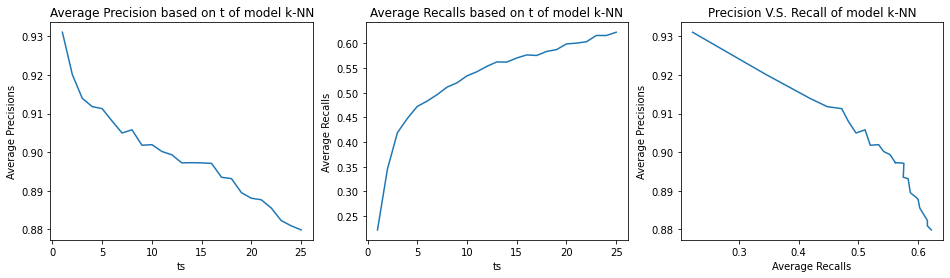

In [ ]:
#@markdown 14A. Plot precision and recall for model k-NN
plot_precision_recall(precision_knn, recall_knn, ts, "k-NN")

In [ ]:
#@markdown 14B. Calculate precision and recall for model NMF
precision_nmf = []
recall_nmf = []
for t in ts:
  precision_at_t = []
  recall_at_t = []
  for trainset, testset in kf.split(data):
    G = getG(testset, t)
    pred = NMF(n_factors=18,verbose=False).fit(trainset).test(G)
    precision, recall = calculate_precision_recall(pred, t)
    precision_at_t.append(precision)
    recall_at_t.append(recall)
  precision_nmf.append(np.mean(precision_at_t))
  recall_nmf.append(np.mean(recall_at_t))

<Figure size 432x288 with 0 Axes>

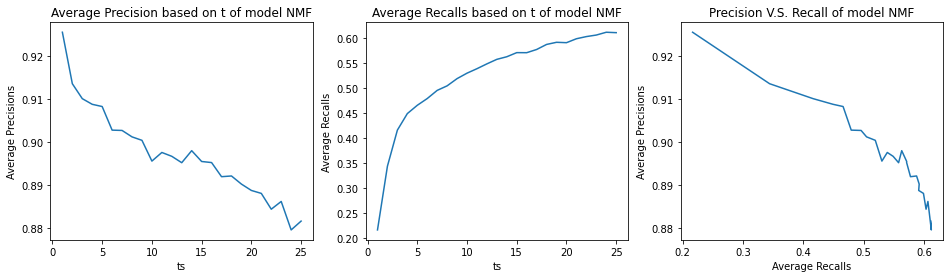

In [ ]:
#@markdown 14B. Plot precision and recall for model NMF
plot_precision_recall(precision_nmf, recall_nmf, ts, "NMF")

In [ ]:
#@markdown 14C. Calculate precision and recall for model MF
precision_mf = []
recall_mf = []
for t in ts:
  precision_at_t = []
  recall_at_t = []
  for trainset, testset in kf.split(data):
    G = getG(testset, t)
    pred = SVD(n_factors=18,verbose=False).fit(trainset).test(G)
    precision, recall = calculate_precision_recall(pred, t)
    precision_at_t.append(precision)
    recall_at_t.append(recall)
  precision_mf.append(np.mean(precision_at_t))
  recall_mf.append(np.mean(recall_at_t))

<Figure size 432x288 with 0 Axes>

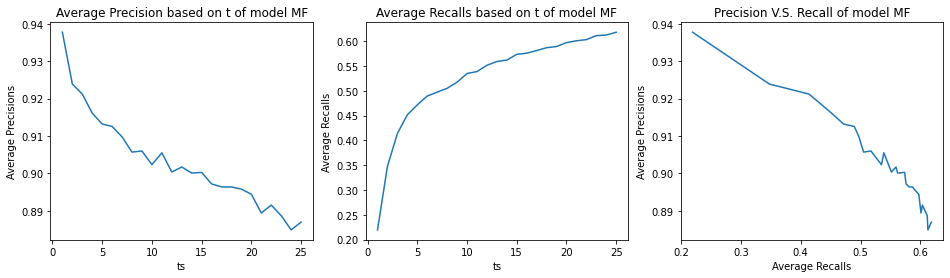

In [ ]:
#@markdown 14C. Plot precision and recall for model MF
plot_precision_recall(precision_mf, recall_mf, ts, "MF")